<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Solving-the-system-of-differential-equations" data-toc-modified-id="Solving-the-system-of-differential-equations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Solving the system of differential equations</a></span></li><li><span><a href="#Looking-at-the-evolution-of-the-phase" data-toc-modified-id="Looking-at-the-evolution-of-the-phase-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Looking at the evolution of the phase</a></span><ul class="toc-item"><li><span><a href="#Showing-the-phases-moving-around-the-circle" data-toc-modified-id="Showing-the-phases-moving-around-the-circle-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Showing the phases moving around the circle</a></span></li></ul></li><li><span><a href="#How-does-the-final-coherence-depend-on-the-coupling-strength-K?" data-toc-modified-id="How-does-the-final-coherence-depend-on-the-coupling-strength-K?-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>How does the final coherence depend on the coupling strength K?</a></span><ul class="toc-item"><li><span><a href="#Finding-the-value-of-K-that-leads-to-the-highest-synchronization" data-toc-modified-id="Finding-the-value-of-K-that-leads-to-the-highest-synchronization-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Finding the value of K that leads to the highest synchronization</a></span></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import rc
from IPython.display import Image

# Introduction

After having read Steven H. Strogatz' book _Sync: The Emerging Science of Spontaneous Order_ my interest in spontaneous synchronization was spiked. One reason for this is the fact that I am currently analyzing electrocardiograms at work, and one of the examples in the book of the syncrhonization (or lack thereof) is the heart and the dangerouse arytmia that can come out of nowhere.

The aim of this notebook is to reproduce the results reported by Steven H. Strogatz and Renato E. Mirollo in 1991. It contains a simulation of the Kuramoto model, which should exhibbit some of the same charactertistics as the pacemaker cells in the heat.

# Solving the system of differential equations

The system of differential equations to be solved is:
$$
 \dot\theta_i = \omega_i + \frac{K}{N} \sum\limits_{j=1}^{N} \sin \left( \theta_j - \theta_i \right)
$$

Here $\theta_i$ is the phase of the _ith_ oscillator, $\omega_i$ is its natural frequency, and $K\geq0$ is the coupling strength.

The statement i want to reproduce is the following:

> The system (1.1) was studied for the case of N=480 oscillators, with
coupling strength $K=1$. The frequencies were uniformly distributed on $[-\gamma, \gamma]$, where $\gamma=0.2$. There was no noise, i.e., $D=0$. The goal was to simulate the evolution of the system starting near the incoherent solution. For these parameters, equation (3.15b) predicts that the coherence $r(t)$ should initially grow exponentially at a rate $\alpha \approx 0.47304$.

How exactely is the coherence ($r(t)$) defined?

In [2]:
def calc_theta_dot(omega, theta, N, K):
    theta_dot = np.zeros( (N,))
    for i in range(N):
        theta_dot[i] = omega[i] + (K/N)*np.sum( np.sin(theta-theta[i]) )
    return theta_dot

In [3]:
def set_up_initial_conditions(N=800):
    omega = np.random.uniform(-0.2, 0.2, N)
    theta = np.random.uniform(0, 2, N)*np.pi
    return omega, theta

Below I set up the initial values as described above and look at the distribution to make sure that it looks uniform.

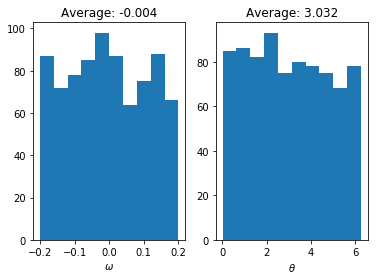

In [4]:
omega, theta = set_up_initial_conditions()

fig, ax = plt.subplots(ncols=2)
ax[0].hist(omega)
ax[1].hist(theta)

ax[0].set_title('Average: {0:.3f}'.format(np.average(omega)) )
ax[1].set_title('Average: {0:.3f}'.format(np.average(theta)) )

ax[0].set_xlabel(r"$\omega$")
ax[1].set_xlabel(r"$\theta$");

In [5]:
def run_simulation(omega, theta, N=480, K=1, STEPS=25):
    thetas = np.zeros( (N, STEPS) )
    for i in range(STEPS):
        theta_dot = calc_theta_dot(omega, theta, N=N, K=K)
        theta = np.mod(theta_dot + theta, 2*np.pi)
        thetas[:,i] = theta
    return thetas

In [6]:
def add_labels(ax, K):
    ax.set_ylabel(r"$\theta$")
    ax.set_xlabel("Time steps")

    yticks = [0, 0.5*np.pi, np.pi, 1.5*np.pi, 2*np.pi]
    yticks_labels = [r"0", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"]
    
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks_labels);
    
    ax.set_title("K={0}".format(K))
    
def add_relaxation_labels(ax):
    ax.set_ylabel(r"$Var(\theta)$")
    ax.set_xlabel(r"$\log_{10}$(Time steps)")
    ax.set_ylim([0, 2*np.pi])

In [7]:
STEPS = 100
K = 1
N = 480
omega, theta = set_up_initial_conditions(N=N)
thetas = run_simulation(omega, theta, N=N, K=K, STEPS=STEPS)

# Looking at the evolution of the phase

## Showing the phases moving around the circle
In the book Stogatz asks the reader to think of each spring as a runner on a track. The runners influence each others speed. If Synch arises, this would mean that the runners end up running around the track bundled up in a group. Lets visualize the simulation like this -- the phase of each oscillator will be converted to (x,y) points on a circle.

I have made the points transparrent so it the clumping up becomes more aparrent. 

In [8]:
%%capture 
# This line is here to supress the output of a empty fiure
rc('animation', html='html5')
fig, ax = plt.subplots(figsize=(4,4));
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(( -1.1, 1.1))
ax.set_ylim((-1.1, 1.1))

dots, = ax.plot([], [], 'ob', alpha=0.2)
def init():
    dots.set_data([], [])
    return (dots,)

def animate(i):
    x,y = np.cos(thetas[:,i]), np.sin(thetas[:,i])
    dots.set_data(x, y)
    ax.set_title('Step: {0}'.format(i))
    return (dots,)

anim = FuncAnimation(fig, animate, init_func=init,
                               frames=thetas.shape[1], interval=200);

To show the animation in the notebook on GitHub, I need to save it as a .gif file and include it. This is done below.

In [9]:
!brew install imagemagick

Error: imagemagick 7.0.7-21 is already installed
To upgrade to 7.0.7-28, run `brew upgrade imagemagick`


In [10]:
anim.save('animation.gif', writer='imagemagick', fps=3)

In [11]:
Image(url='animation.gif')

Below I show the phase of each oscillator for each time step together with the average phase of all the oscillators.

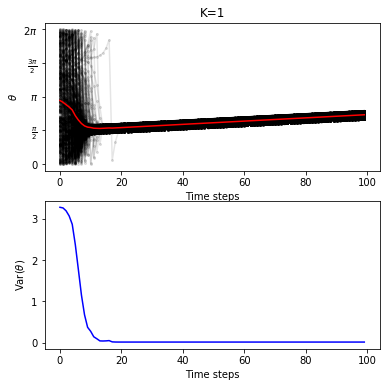

In [12]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(6,6))
for i in range(thetas.shape[0]):
    ax[0].plot(range(STEPS), thetas[i,:], '-ok', alpha=0.1, markersize=2)
    
avg = np.average(thetas, axis=0)
ax[0].plot(range(STEPS), avg, '-r')
add_labels(ax[0], K)

var = np.var(thetas, axis=0)
ax[1].plot(range(STEPS), var, '-b')
ax[1].set_xlabel('Time steps')
ax[1].set_ylabel(r'Var($\theta$)');

Because the preferred frequency of each oscillator uniformly distributed between -0.2 and 0.2 the oscillators often end up in a fairly stable stable situation where the phase does not change much over time.

# How does the final coherence depend on the coupling strength K?

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


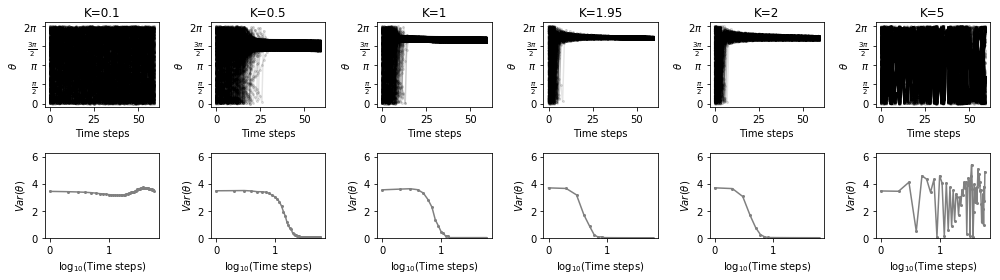

In [13]:
fig, axes = plt.subplots(ncols=6, nrows=2, figsize=(14,4))
STEPS = 60
Ks = [0.1, 0.5, 1, 1.95, 2, 5]
initial_omega, initial_theta = set_up_initial_conditions(N=480)
for idx, K in enumerate(Ks):
    omega, theta = initial_omega, initial_theta
    thetas = run_simulation(omega, theta, N=480, STEPS=STEPS, K=K)
    for i in range(thetas.shape[0]):
        axes[0, idx].plot(range(STEPS), thetas[i,:], '-ok', alpha=0.1, markersize=2)
        add_labels(axes[0, idx], K)
    axes[1, idx].plot(np.log10(range(STEPS)), np.var(thetas, axis=0), '-o', color='grey', markersize=2)
    add_relaxation_labels(axes[1, idx])
        
fig.tight_layout()

## Finding the value of K that leads to the highest synchronization
Above we saw that coupling strength influence how synchronized the oscillators end up being -- to low or too high no synchronization will take place. In between there seem to be a sweet spot, so is there an optimal value? Lets check.

In [14]:
STEPS = 50
N = 600
Ks = np.arange(0,3.01,0.01)
variances = np.zeros( (len(Ks), STEPS) )
end_variances = np.zeros( (len(Ks), ) )
initial_omega, initial_theta = set_up_initial_conditions(N=N)
for idx, K in enumerate(Ks):
    omega, theta = initial_omega, initial_theta
    thetas = run_simulation(omega, theta, N=N, STEPS=STEPS, K=K)
    end_variances[idx] = np.var(thetas[:,-1])
    variances[idx, :] = np.var(thetas, axis=0)
    

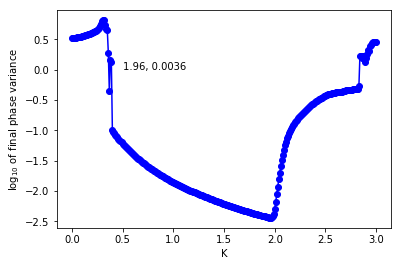

In [15]:
lowest_variance = np.min(end_variances)
K_at_lowest_variance = Ks[np.where(end_variances==lowest_variance)][0]

fig, ax = plt.subplots()

ax.plot(Ks, np.log10(end_variances), '-ob');

ax.text(0.5, 0, "{0:.2f}, {1:.4f}".format(K_at_lowest_variance, lowest_variance) )

ax.set_xlabel('K')
ax.set_ylabel(r'$\log_{10}$ of final phase variance');

So it would appear that a coupling close to $K=1.95$ leads to the lowest variance in the final phase reached by the oscillators in the simulation.

# Conclusion
We have seen that a collection of coupled oscillators set up with a uniform distribution of preferred oscillation frequencies can end up all oscillating with a frequency close to each other.